# Imports

In [2]:
from concurrent.futures import ThreadPoolExecutor
import os
from pathlib import Path
from typing import Optional
from src.data.paths import project_dir
from src.data.analysis import Circle, get_mean_std, get_timestamp, create_circular_mask

import numpy as np
import numpy.typing as npt
from scipy import ndimage
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  
from matplotlib.patches import Circle as CirclePatch

In [3]:
from typing import List
def read_df(path : Path , det_names : List[str], analysis_radius : float = 300) -> pd.DataFrame:
    df = pd.DataFrame()
    df["det_id"] = det_names
    df.det_id = df.det_id.astype('uint8')
    df["raw_data"] = df.det_id.apply(lambda id: np.load(path / f"{id}" / "raw.npy"))
    df["timestamp"] = df.det_id.apply(lambda id: get_timestamp(path / f"{id}" / "metadata.txt"))
    df["det_circle"] = df.det_id.apply(lambda x: Circle.from_json(path / f"{x}lv" / "det-circle.json"))
    df["det_angle"] = df.det_id.apply(lambda id: np.load(path / f"{id}lv" / "angle.npy"))
    df["raw_mean_center"] = df.apply(lambda tmpdf: get_mean_std(tmpdf.raw_data, tmpdf.det_circle)[0], axis=1)
    df["raw_std_center"] = df.apply(lambda tmpdf: get_mean_std(tmpdf.raw_data, tmpdf.det_circle)[1], axis=1)

    df['analysis_circle'] = df.det_circle.apply(lambda c: Circle(c.x, c.y, analysis_radius))
    df["raw_mean"] = df.apply(lambda tmpdf: get_mean_std(tmpdf.raw_data, tmpdf.analysis_circle)[0], axis=1)
    df["raw_std"] = df.apply(lambda tmpdf: get_mean_std(tmpdf.raw_data, tmpdf.analysis_circle)[1], axis=1)
    return df

# Data reading

In [60]:
pre_irr_bg = project_dir / "data" / "interim" / "foils" / "2022_11_23_background"
pre_irr_bg_ids = sorted((entry.name for entry in pre_irr_bg.iterdir() if entry.name.isdigit()), key=lambda s: int(s))
df_pre_bg = read_df(pre_irr_bg, pre_irr_bg_ids)
df_pre_bg["label"] = "pre_irr_bg"
# df_pre_bg.head()

In [61]:
data_co60 = project_dir / "data" / "interim" / "foils" / "2022_11_23_Co60"
data_co60_ids = sorted((entry.name for entry in data_co60.iterdir() if entry.name.isdigit()), key=lambda s: int(s))
df_Co60 = read_df(data_co60, data_co60_ids)
df_Co60["label"] = "Co60"
# df_Co60.head()

In [62]:
ff_image_path = project_dir / "data" / "interim" / "foils" / "2022_08_22_flat_field" / "FF_2sLED_U340" / "FF_1" / "raw.npy"
ff_data = np.load(ff_image_path)

In [63]:
# apply correction for sensor stability as function of time
x = df_pre_bg.timestamp.apply(lambda x: (x - df_pre_bg.timestamp.min()).total_seconds()).values
y = df_pre_bg.raw_mean_center.values
a,b = np.polyfit(x, y, 1)
print(f"a = {a}, b = {b}")

df_pre_bg["raw_data_stabilised"] = df_pre_bg.apply(lambda x: x.raw_data - a * (x.timestamp - df_pre_bg.timestamp.min()).total_seconds() , axis=1)
df_Co60["raw_data_stabilised"] = df_Co60.apply(lambda x: x.raw_data - a * (x.timestamp - df_Co60.timestamp.min()).total_seconds() , axis=1)

df_pre_bg["raw_mean_stabilized"] = df_pre_bg.apply(lambda tmpdf: get_mean_std(tmpdf.raw_data_stabilised, tmpdf.analysis_circle)[0], axis=1)
df_Co60["raw_mean_stabilized"] = df_Co60.apply(lambda tmpdf: get_mean_std(tmpdf.raw_data_stabilised, tmpdf.analysis_circle)[0], axis=1)

a = 0.001687053830354033, b = 1039.8119645231088


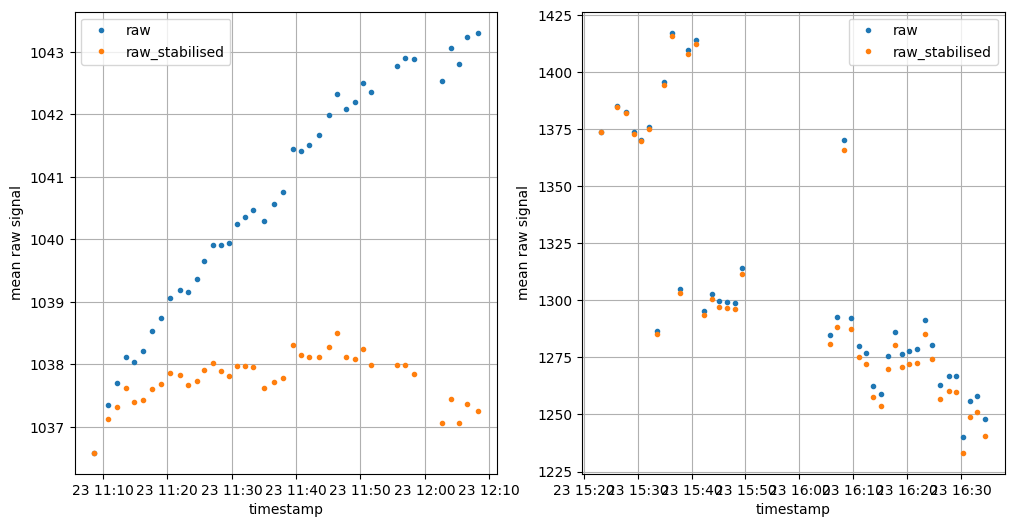

In [66]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))

axes[0].plot(df_pre_bg.timestamp, df_pre_bg.raw_mean, '.', label="raw")
axes[0].plot(df_pre_bg.timestamp, df_pre_bg.raw_mean_stabilized, '.', label="raw_stabilised")

axes[1].plot(df_Co60.timestamp, df_Co60.raw_mean, '.', label="raw")
axes[1].plot(df_Co60.timestamp, df_Co60.raw_mean_stabilized, '.', label="raw_stabilised")

for ax in axes:
    ax.set_xlabel("timestamp")
    ax.set_ylabel("mean raw signal")
    ax.legend()
    ax.grid();

# Data inspection

In [67]:

def singal_df(df_data : pd.DataFrame, df_bg : pd.DataFrame, ff_array : Optional[npt.NDArray] = None, analysis_radius : float = 300) -> pd.DataFrame:
    df_signal = df_data.copy()
    df_signal.set_index("det_id", inplace=True)

    # remove background
    df_bg.set_index("det_id", inplace=True)
    df_signal["bg_sub"] = df_signal.raw_data - df_bg.raw_data
    df_signal["bg_sub_stabilized"] = df_signal.raw_data_stabilised - df_bg.raw_data_stabilised
    df_bg.reset_index(inplace=True)

    # apply FF
    df_signal["sensor_corr"] = df_signal.bg_sub
    if ff_array is not None:
        big_circle = Circle(x=ff_array.shape[1]/2, y=ff_array.shape[0]/2, r=ff_array.shape[1]/2-10)
        mask = create_circular_mask(img=ff_data, circle_px=big_circle)
        gain =  ff_array / np.mean(ff_array[mask])
        df_signal["sensor_corr"] = df_signal.bg_sub.apply(lambda x: x / gain)
        
    # move to center, faster version using multiple threads
    no_of_cpus = os.cpu_count()
    if no_of_cpus is None:
        no_of_cpus = 1
    def shift(data: npt.NDArray, x : float, y : float) -> npt.NDArray:
        return ndimage.shift(data, (data.shape[1]/2-y,data.shape[0]/2-x), cval=np.nan, prefilter=False)
    def apply_shift(df : pd.DataFrame) -> pd.Series:
        return df.apply(lambda x: shift(x.sensor_corr, x.det_circle.x, x.det_circle.y), axis=1)    
    with ThreadPoolExecutor() as executor:
        chunks_of_shifted_df = executor.map(apply_shift, np.array_split(df_signal, no_of_cpus))
    df_signal["centered"] = pd.concat(chunks_of_shifted_df)

    df_signal["analysis_circle_centered"] = df_signal.apply(lambda x: pd.Series(Circle(x.centered.shape[0]//2, x.centered.shape[1]//2, analysis_radius)), axis=1)
    df_signal["detector_circle_centered"] = df_signal.apply(lambda x: pd.Series(Circle(x.centered.shape[0]//2, x.centered.shape[1]//2, x.det_circle.r)), axis=1)
    
    # rotate
    def rotate(data: npt.NDArray, angle_deg : float) -> npt.NDArray:
        return ndimage.rotate(data, -angle_deg, cval=np.nan, reshape=False, prefilter=False)
    def apply_rotate(df : pd.DataFrame) -> pd.Series:
        return df.apply(lambda x: rotate(x.centered, x.det_angle), axis=1)
    with ThreadPoolExecutor() as executor:
        chunks_of_rotated_df = executor.map(apply_rotate, np.array_split(df_signal, no_of_cpus))
    df_signal["rotated"] = pd.concat(chunks_of_rotated_df)
    
    return df_signal

In [68]:
signal_Co60 = singal_df(df_Co60, df_bg=df_pre_bg, ff_array=ff_data)
#signal_Co60.head()

In [70]:
signal_Co60["bg_sub_mean"] = signal_Co60.apply(lambda tmpdf: get_mean_std(tmpdf.bg_sub, tmpdf.analysis_circle_centered)[0], axis=1)
signal_Co60["bg_sub_stabilized_mean"] = signal_Co60.apply(lambda tmpdf: get_mean_std(tmpdf.bg_sub_stabilized, tmpdf.analysis_circle_centered)[0], axis=1)

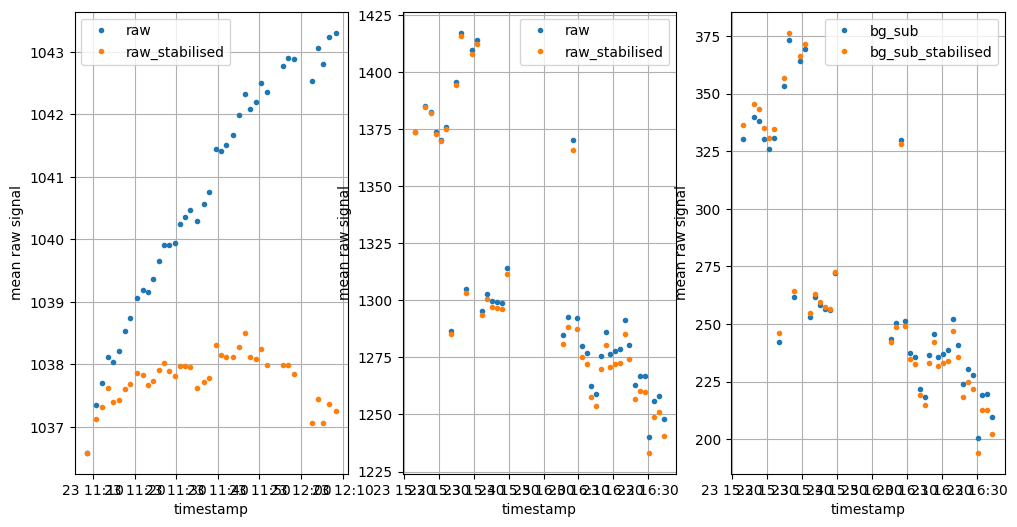

In [71]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 6))

axes[0].plot(df_pre_bg.timestamp, df_pre_bg.raw_mean, '.', label="raw")
axes[0].plot(df_pre_bg.timestamp, df_pre_bg.raw_mean_stabilized, '.', label="raw_stabilised")

axes[1].plot(df_Co60.timestamp, df_Co60.raw_mean, '.', label="raw")
axes[1].plot(df_Co60.timestamp, df_Co60.raw_mean_stabilized, '.', label="raw_stabilised")

axes[2].plot(signal_Co60.timestamp, signal_Co60.bg_sub_mean, '.', label="bg_sub")
axes[2].plot(signal_Co60.timestamp, signal_Co60.bg_sub_stabilized_mean, '.', label="bg_sub_stabilised")

for ax in axes:
    ax.set_xlabel("timestamp")
    ax.set_ylabel("mean raw signal")
    ax.legend()
    ax.grid();

# Inspection

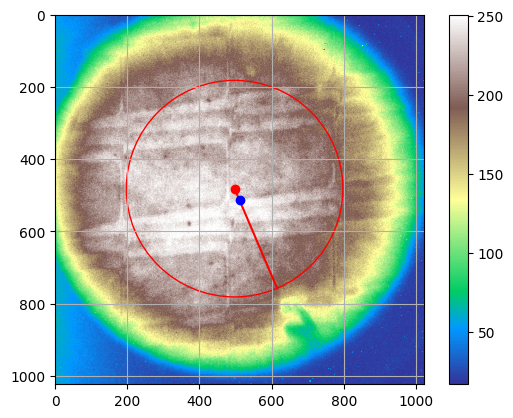

In [52]:
def plot_2d(data: npt.NDArray,
            circle: Optional[Circle] = None,
            angle_deg: Optional[float] = None,
            ax: Optional[plt.Axes] = None,
            a_min: Optional[float] = None,
            a_max: Optional[float] = None,
            cbar: bool = True,
            **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    current_a_min = a_min
    if a_min is None:
        current_a_min = np.nanpercentile(a=data, q=3)
    current_a_max = a_max
    if a_max is None:
        current_a_max = np.nanpercentile(a=data, q=97)
    im = ax.imshow(np.clip(data, a_min=current_a_min, a_max=current_a_max), cmap="terrain", **kwargs)
    if cbar:
        ax.figure.colorbar(im, ax=ax)
    if circle is not None:
        ax.add_artist(CirclePatch((circle.x, circle.y), circle.r, fill=False, color="red"))
        # add a point to the center of the circle
        ax.plot(circle.x, circle.y, "ro")
        if angle_deg is not None:
            angle_rad = np.deg2rad(angle_deg)
            radius_line = Line2D([circle.x, circle.x - circle.r * np.sin(angle_rad)],
                                 [circle.y, circle.y - circle.r * np.cos(angle_rad)],
                                 color="red")
            ax.add_artist(radius_line)
    ax.plot(data.shape[1] / 2, data.shape[0] / 2, "bo")
    ax.grid()
    return ax

ind = 0
plot_2d(signal_Co60.iloc[ind].raw_data - 1024, signal_Co60.iloc[ind].analysis_circle, signal_Co60.iloc[ind].det_angle);

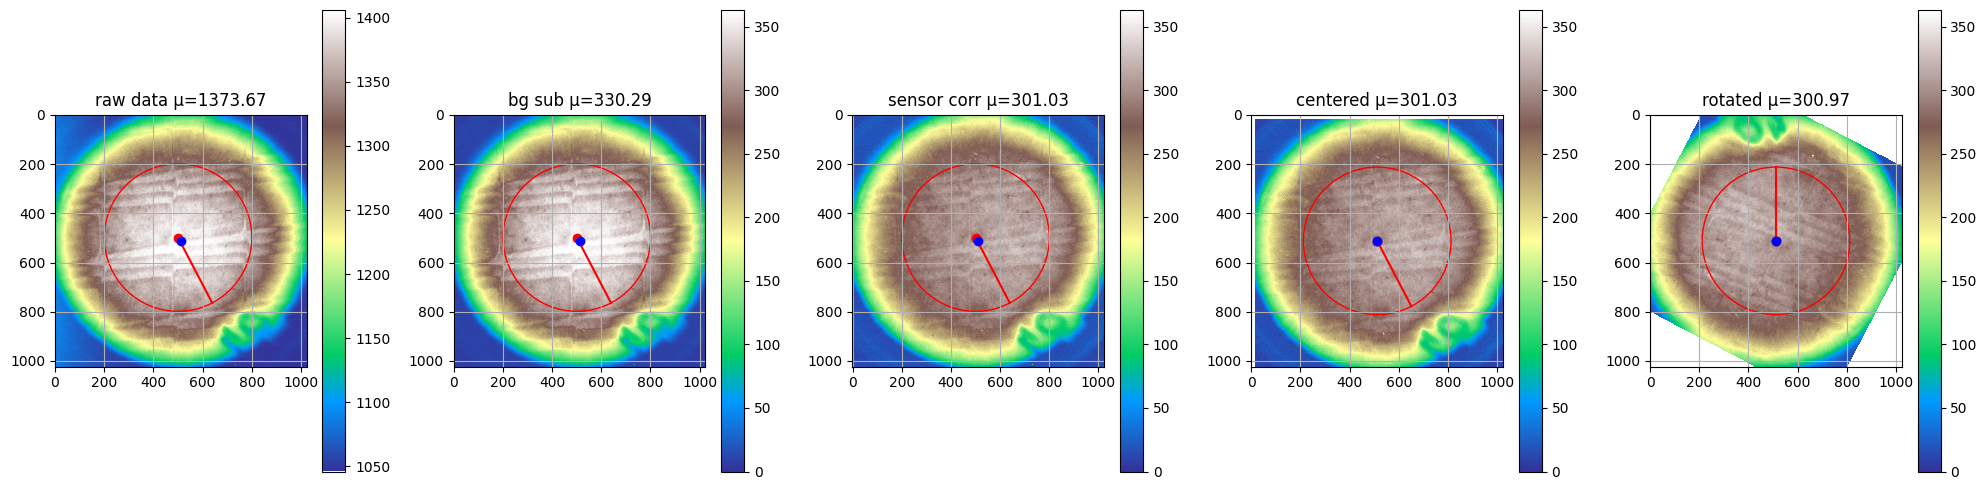

In [69]:
fig, axes = plt.subplots(ncols=5, figsize=(20, 5))

ind = 39
plot_2d(signal_Co60.iloc[ind].raw_data, signal_Co60.iloc[ind].analysis_circle, signal_Co60.iloc[ind].det_angle, ax=axes[0])
axes[0].set_title(f"raw data μ={get_mean_std(signal_Co60.iloc[ind].raw_data, signal_Co60.iloc[ind].analysis_circle)[0]:.2f}")

a_min = 0
a_max = np.percentile(a=signal_Co60.iloc[ind].bg_sub, q=97)
plot_2d(signal_Co60.iloc[ind].bg_sub, signal_Co60.iloc[ind].analysis_circle, signal_Co60.iloc[ind].det_angle, ax=axes[1], a_min=a_min, a_max=a_max)
axes[1].set_title("bg sub μ={:.2f}".format(get_mean_std(signal_Co60.iloc[ind].bg_sub, signal_Co60.iloc[ind].analysis_circle)[0]))

plot_2d(signal_Co60.iloc[ind].sensor_corr, signal_Co60.iloc[ind].analysis_circle, signal_Co60.iloc[ind].det_angle, ax=axes[2], a_min=a_min, a_max=a_max)
axes[2].set_title("sensor corr μ={:.2f}".format(get_mean_std(signal_Co60.iloc[ind].sensor_corr, signal_Co60.iloc[ind].analysis_circle)[0]))

plot_2d(signal_Co60.iloc[ind].centered, signal_Co60.iloc[ind].analysis_circle_centered, signal_Co60.iloc[ind].det_angle, ax=axes[3], a_min=a_min, a_max=a_max)
axes[3].set_title("centered μ={:.2f}".format(get_mean_std(signal_Co60.iloc[ind].centered, signal_Co60.iloc[ind].analysis_circle_centered)[0]))

plot_2d(signal_Co60.iloc[ind].rotated, signal_Co60.iloc[ind].analysis_circle_centered, 0, ax=axes[4], a_min=a_min, a_max=a_max)
axes[4].set_title("rotated μ={:.2f}".format(get_mean_std(signal_Co60.iloc[ind].rotated, signal_Co60.iloc[ind].analysis_circle_centered)[0]));

fig.tight_layout()